A data scientist at company XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. She therefore went and talked to the international team in charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish- speaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Nicaraguan users would see a translation written by an Nicaraguan, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.

After they run the test, however, they are really surprised as the test is negative. That is, it appears that the non-localized translation was doing better!

Questions:

    1) Investigate if the test is actually negative.

    2) Explain why that might be happening. Are the localized translations really worse?

    3) If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the

    results can be trusted.


In [364]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from scipy import stats


In [365]:
## Reading the dataset into a dataframe from csv
test_df = pd.read_csv('./Desktop/Translation_Test__281_29/test_table.csv') 
user_df = pd.read_csv('./Desktop/Translation_Test__281_29/user_table.csv')

In [366]:
user_df.isnull().any() ## Checking for any null values in the dateset


user_id    False
sex        False
age        False
country    False
dtype: bool

In [367]:
test_df.isnull().any() ## Checking for any null values in the dateset. 

user_id             False
date                False
source              False
device              False
browser_language    False
ads_channel          True
browser             False
conversion          False
test                False
dtype: bool

Looks like some values in the ads_channel column is null. We need to take care of it later on.

In [368]:
test_df.dtypes # checking the data type of each column

user_id              int64
date                object
source              object
device              object
browser_language    object
ads_channel         object
browser             object
conversion           int64
test                 int64
dtype: object

In [369]:
#converting the dtype of 'date' column to datetime
test_df['date'] = pd.to_datetime(test_df['date'])


In [370]:
#Check for number of unique user_id values in the test_data.
#Since the number of unique user_id values match the number of rows, 
#we can conclude there are no duplicates

test_df.user_id.nunique() == test_df.shape[0]

True

In [371]:
#same for user_df. check for duplicate values

user_df.user_id.nunique() == user_df.shape[0] 

True

In [372]:
#Checking to see if every user in the user table has a row in the test table.
test_df.shape[0] - user_df.shape[0]

454

Here we see that there are more rows in the test_data than in the user_data. Which could possibly mean that we have some users missing in the user_data table

In [373]:
#In order to analyze the data more clearly it is required to join these 2 tables. 
#There is a user_id column on which the tables can be merged.

comp_df = test_df.merge(user_df, on='user_id', how='left')

I am doing a left join here in order to not lose data from the test table. The resulting table comp_df will now have the number of rows equal to that of the test_df

In [374]:
comp_df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [375]:
comp_df.describe()

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,NaN
50%,500019.000000,0.000000,0.000000,NaN
75%,749522.000000,0.000000,1.000000,NaN
max,1000000.000000,1.000000,1.000000,70.000000


<h1> First question : Investigate if the test is actually negative.</h1>

<b>  Let's check if the data indeed says that localized translation wasn't that great a success</b>

Taking a look at the data country wise might give us some idea if the result was indeed unsuccessful.

In [376]:
country_df = comp_df.groupby('country')['conversion'].mean().reset_index()

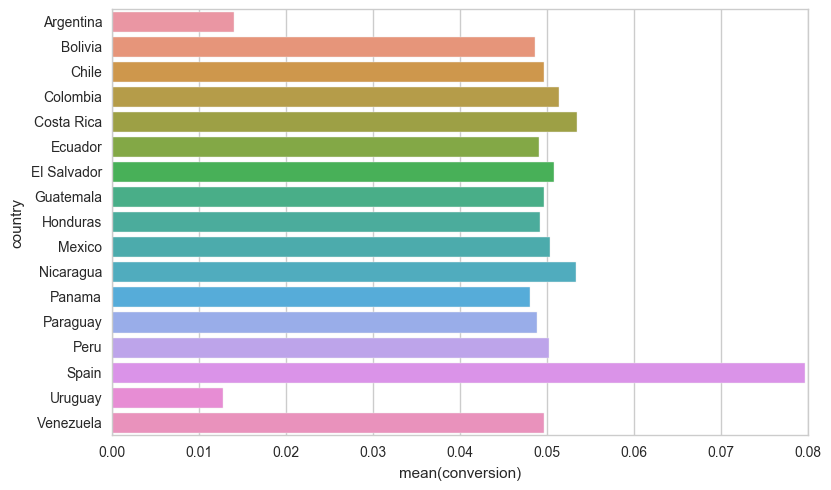

In [377]:
sns.barplot(x='conversion', y='country' , data=country_df)

In [378]:
country_df.sort('conversion', ascending=False)

,country,conversion
14,Spain,0.079719
4,Costa Rica,0.053494
10,Nicaragua,0.053399
3,Colombia,0.051332
6,El Salvador,0.050765
9,Mexico,0.050341
13,Peru,0.050258
2,Chile,0.049704
16,Venezuela,0.049666
7,Guatemala,0.049653


<b> Answering the First question we can clearly see that the conversion rate in Spain is much higher than the rest of the LatAm countries. </b>

Moving on to the rest of the questions as to why this might be happening. Let's take a closer look at the data.

In [379]:
# Let's find out what was the time span of this entire dateset.
comp_df.date.max() - comp_df.date.min()

Timedelta('4 days 00:00:00')

Looks like the entire dataset or the test itself was conducted for 5 days(including the first day here). This is a critical information to keep in mind.

It would be interesting to see what was the proportion of control vs test data. 

In [380]:
print (float(len(comp_df[comp_df['test']==1]))/len(comp_df)) #test data
print (float(len(comp_df[comp_df['test']==0]))/len(comp_df)) #control data

0.47644605037
0.52355394963


The above numbers indicate an approximate half-half split. Now we need to eliminate Spain from the control set as there are no Spain records in the test set.

In [381]:
comp_df = comp_df[comp_df['country']!='Spain']

Once we have done this we can now check for the conversion_rate in both the control and test sets.

In [382]:
test_control = comp_df.groupby('test')['conversion'].mean().reset_index()
test_control

,test,conversion
0,0,0.048330
1,1,0.043425


For the control case we see a conversion rate of 4.8% where as for the test case we clearly see a decrease as it is only 4.3%. 
In most cases, such results which are pretty apparent could be due to the characteristics of data. We need to investigate as to when the data was taken , and if there was some sort of bias in the target demography, etc.
Also the most obvious reason could be that have insufficient data. Like we earlier discovered we only have 5 days worth of data and this could have been on a holiday/weekday,etc. Such things too can cause such results. Let's do a deeper investigation.

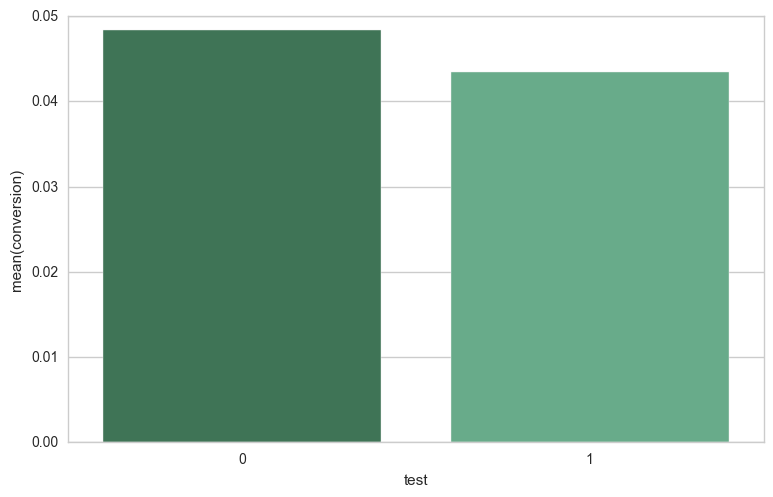

In [383]:
sns.barplot(x='test', y='conversion', data=test_control, palette="BuGn_d")

Let's look to see id there is some kind of specific characteristics in the data that might give us a better idea as to in what circumstances the data was collected and might have influenced the results. For now, we can make an assumption that 5 days data is sufficient but ideally it's recommended to run the tests for longer duration for the above mentioned reasons.

Here I am going to build a model in order to find out what exactly is causing the data to deflect in this manner. More specifically, if there is a specific feature that is causing this kind of deflection.

Let's start by plotting the distribution of each feature for test and control data.

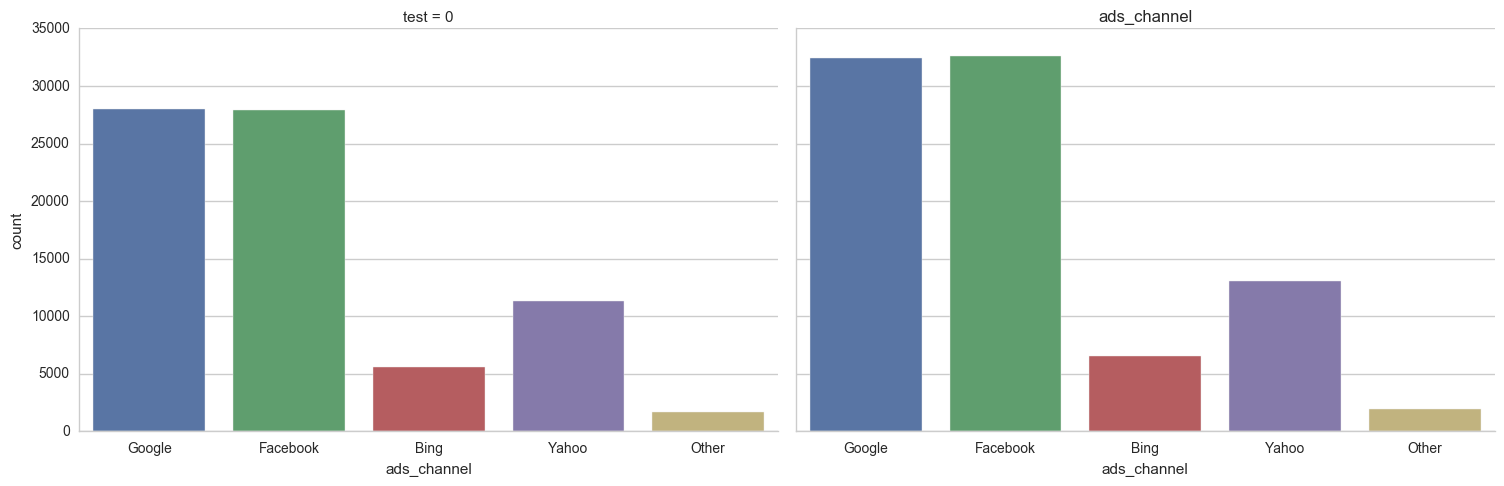

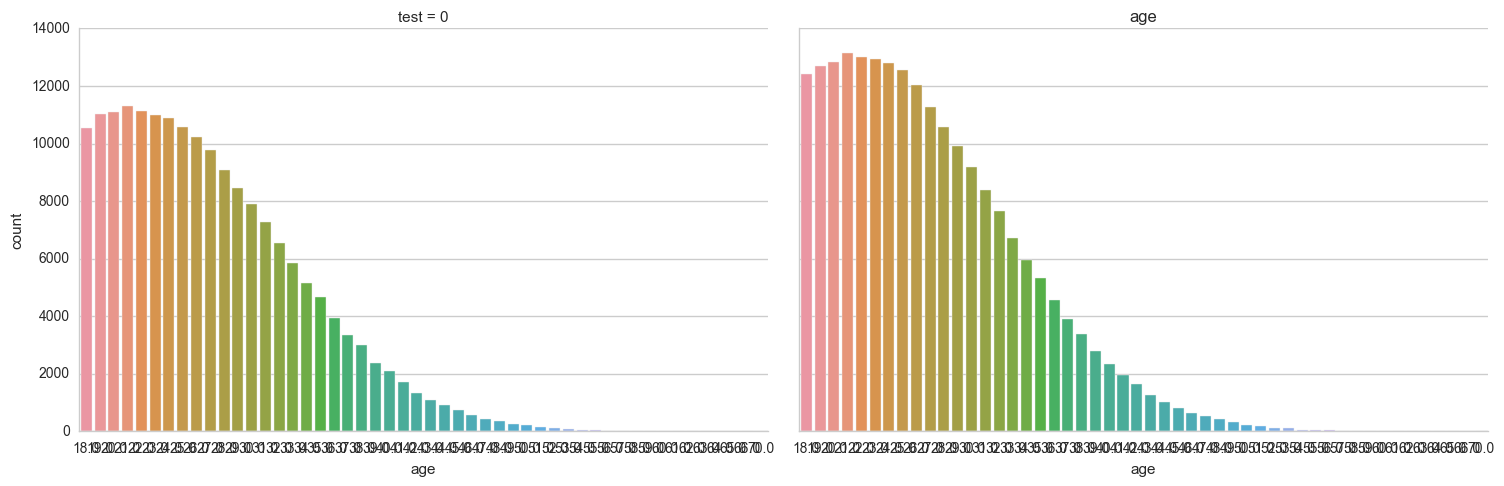

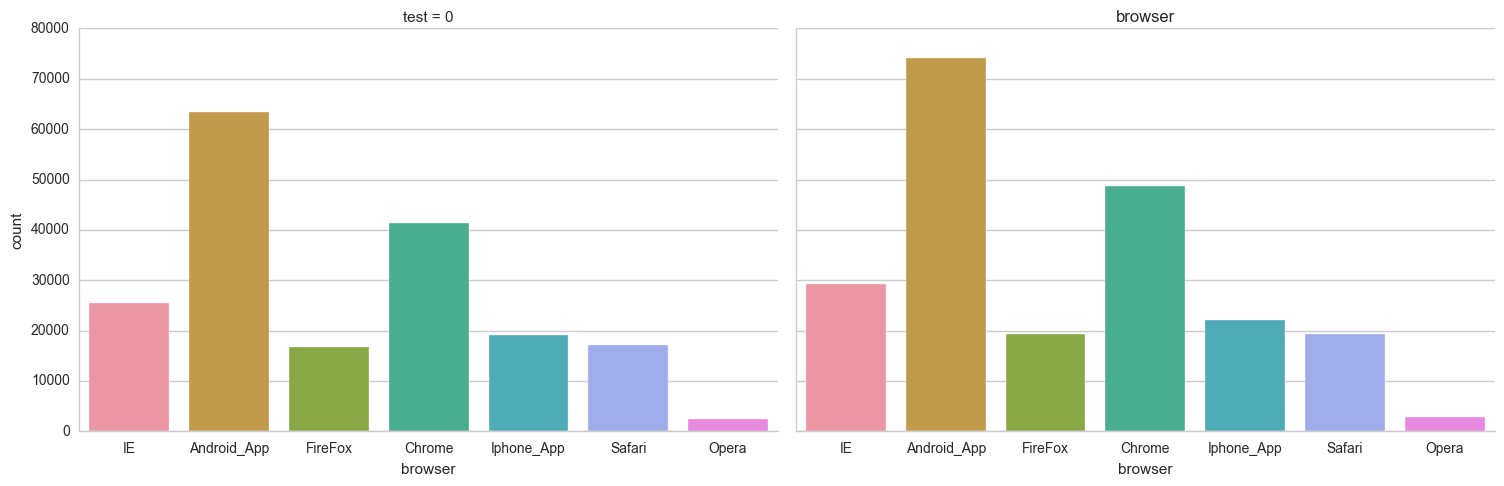

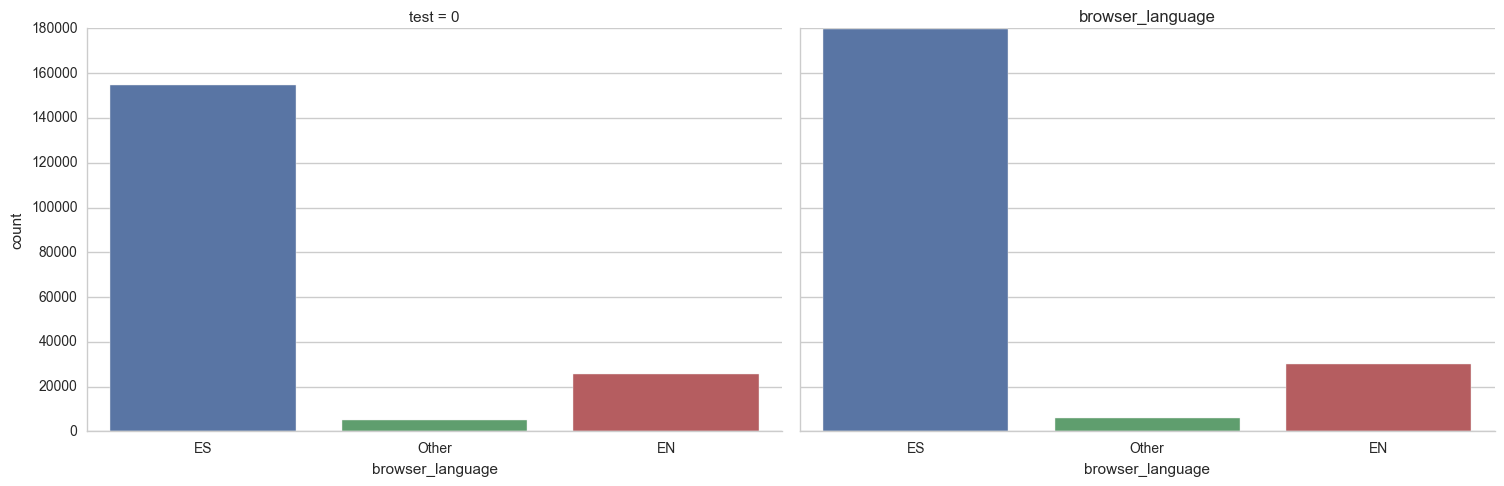

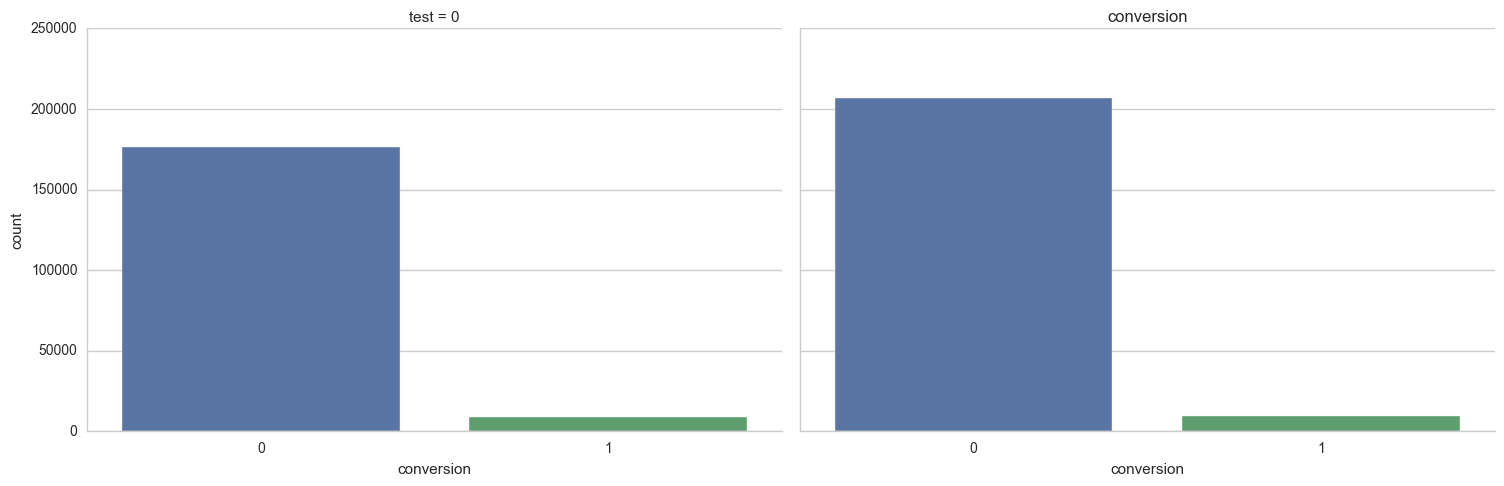

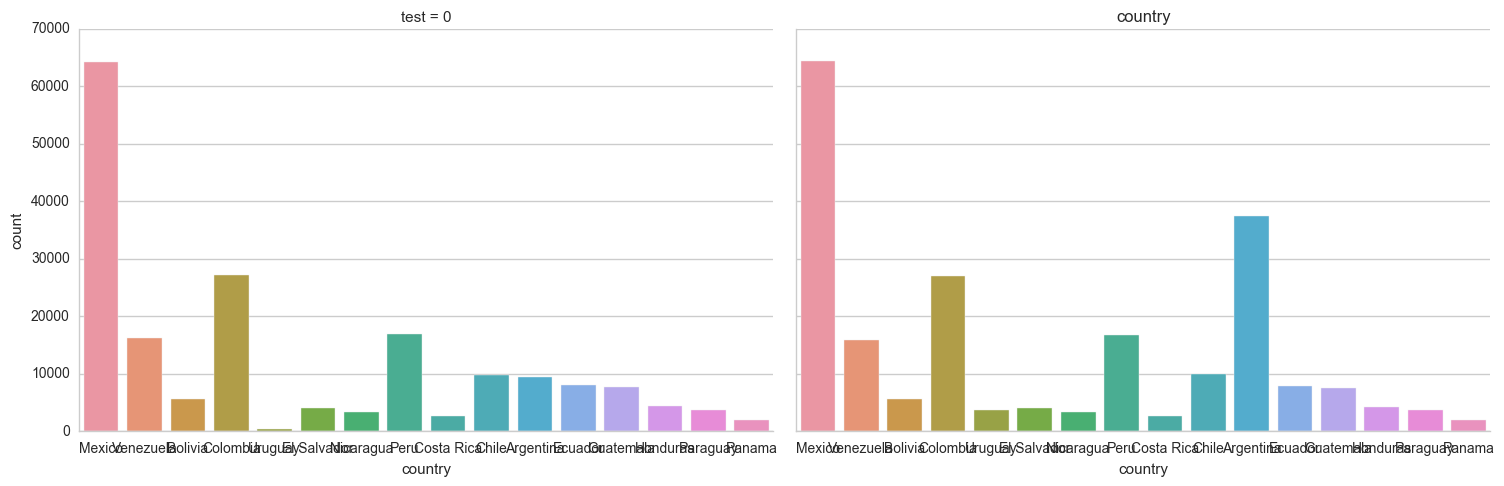

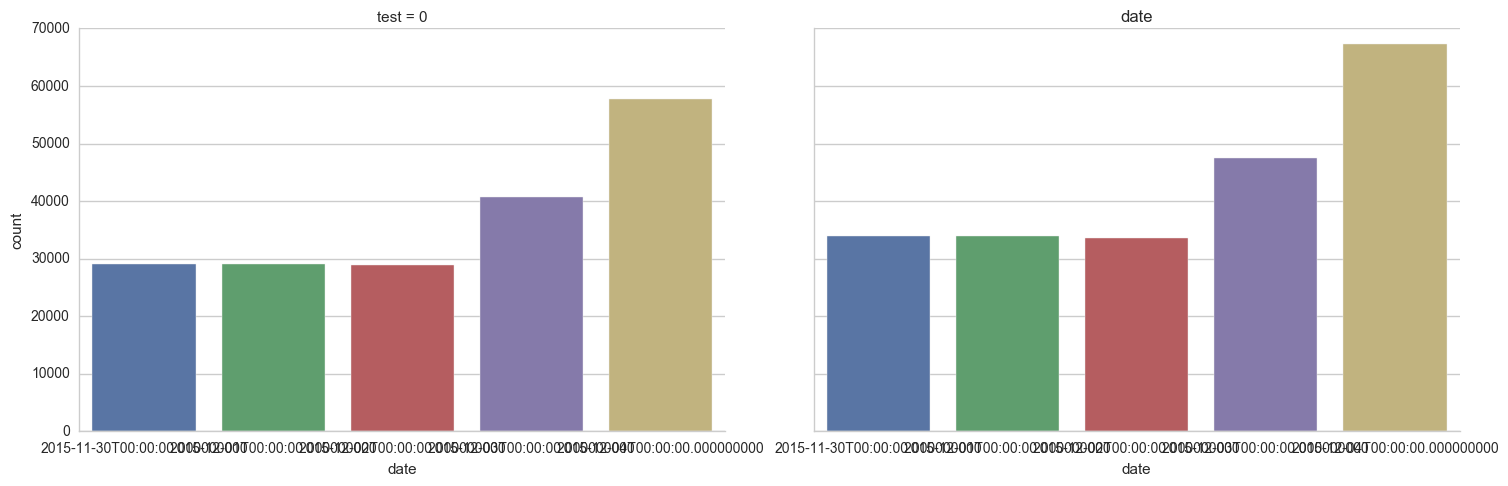

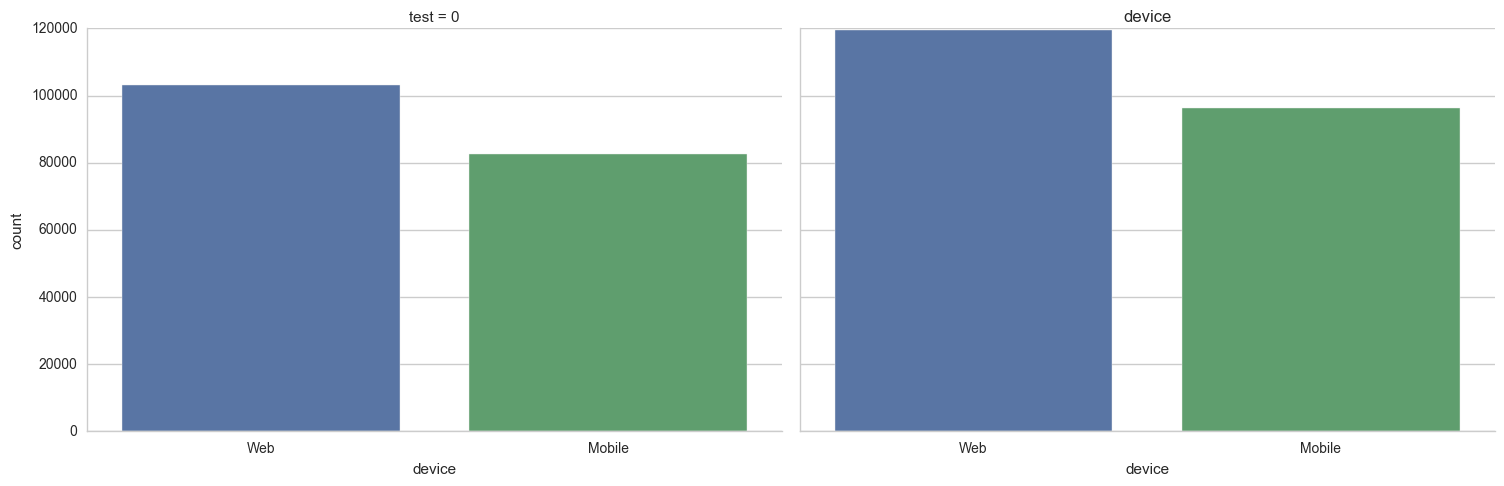

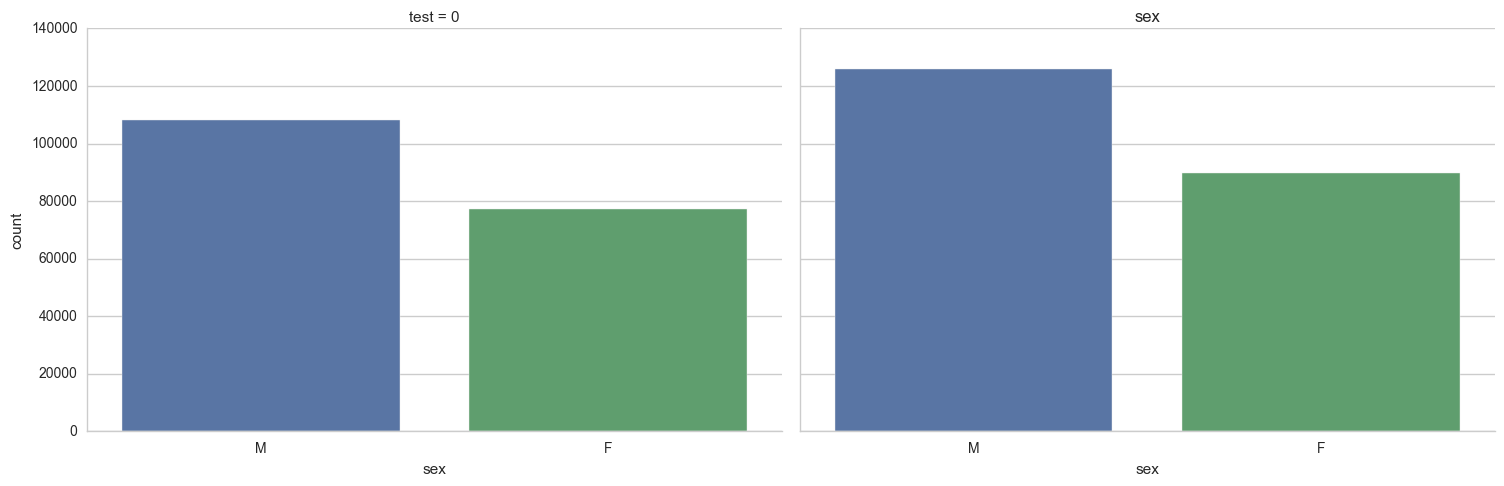

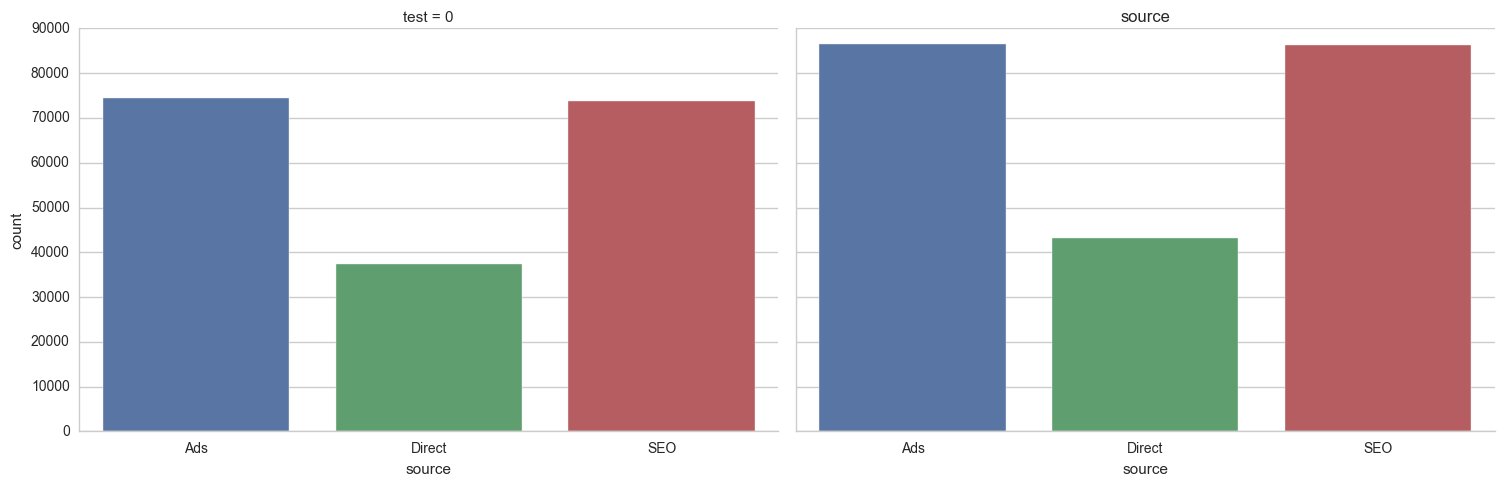

In [384]:
for i in comp_df.columns.difference(['user_id', 'test']):
    sns.factorplot(i, data = comp_df, kind = 'count', col = 'test', size = 5, aspect = 1.5)
    plt.title(i)

We can see from the above plots that there are not any significant differences between the control and test data perse. Except may be a little bit in the age and not sure if it clear, but in the country plots, we see there are more users from Argentina in the test data than in the control data. 

Let's now examine the data by building a model.

In [385]:
comp_df.isnull().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         240555
browser                  0
conversion               0
test                     0
sex                    454
age                    454
country                454
dtype: int64

a. There are null values in 3 columns: sex, age, country, and ads channel
b. We will delete the rows with null values for sex, age and country because it's so few.
c. Since there are so many missing values for ads_channel we will fill create a different colum that raises a 1 when it's a null value and a 0 when it's not.
d. We will investigate the ads_channel to determine whether to erase it or not.

In [386]:
comp_df.dropna(subset=['sex'], inplace=True)

In [407]:
#We are performing a numerical encoding to the categorical features, using the sklearn label encoder.
for feature in ['browser_language', 'country', 'browser', 'ads_channel', 'device', 'source', 'sex']:
    lbl_enc = LabelEncoder()
    lbl_enc.fit(comp_df[feature])
    comp_df[feature] = lbl_enc.transform(comp_df[feature])
    if feature == 'country':
        coun = list(lbl_enc.inverse_transform(comp_df[feature]))


In [388]:
#Fit a Random Forest and check feature importance
feature = ['browser_language', 'country', 'browser', 'ads_channel', 'device', 'source', 'sex', 'age']
model = DecisionTreeClassifier()
#model.fit(map(lambda x: [x],comp_df[features]),comp_df['test'])
model.fit(comp_df[feature], comp_df['test'])
feature_importances = model.feature_importances_


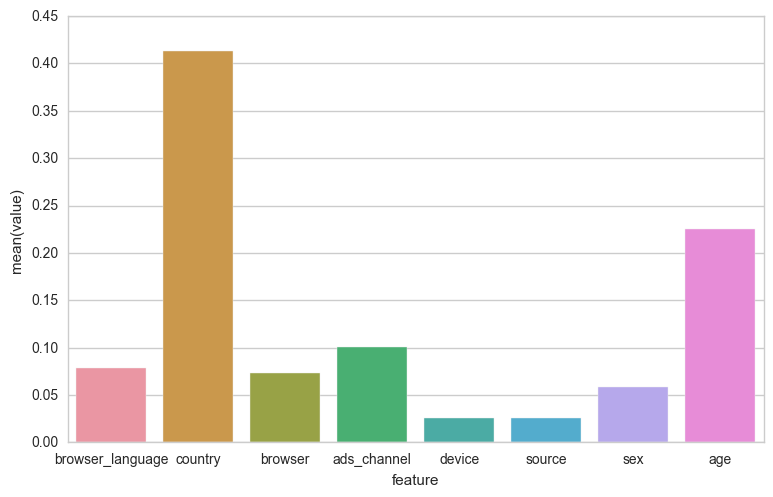

In [389]:
columns = ['feature', 'value']
importance = pd.DataFrame(feature_importances, index=feature).reset_index()
importance.columns = columns
sns.barplot(x='feature', y ='value', data=importance)

Looks like country and age have the maximum impact on the result. Let us quickly check if these are causing any bias.

I am now going to run a basic T-Test to verify and see that if it is indeed the demographical distribution of the control and test data segment results. 

In [404]:
comp_df['country'] = coun
country = []
conversion_test = []
conversion_control = []
p_vals = []
ttest_vals = []
for i in comp_df.country.value_counts().index:
    temp = comp_df[comp_df.country == i]
    cat1 = temp[comp_df.test == 1].conversion
    cat2 = temp[comp_df.test == 0].conversion
    ttest, p =stats.ttest_ind(cat2, cat1)
    country.append(i)
    conversion_test.append(cat1.sum()/float(len(cat1)))
    conversion_control.append(cat2.sum()/float(len(cat2)))

    ttest_vals.append(ttest)
    p_vals.append(p)
    
pd.DataFrame({'country': country, 
              'conversion_test': conversion_test,
              'conversion_control': conversion_control,
             'p_value': p_vals})\
[['country', 'p_value', 'conversion_test', 'conversion_control']]

,country,p_value,conversion_test,conversion_control
0,Mexico,0.165547,0.051186,0.049495
1,Colombia,0.423733,0.050571,0.052089
2,Argentina,0.321766,0.013725,0.015071
3,Peru,0.771950,0.050604,0.049914
4,Venezuela,0.573740,0.048978,0.050344
5,Chile,0.302871,0.051295,0.048107
6,Ecuador,0.961512,0.048988,0.049154
7,Guatemala,0.572165,0.048647,0.050643
8,Bolivia,0.718877,0.047901,0.049369
9,Honduras,0.471721,0.047540,0.050906


This is interesting. With hese p-values we cannot conclude that the difference in translation had any effect on conversion. The above data reflects upon how on controlling the country(and their localized translation) we don't see significances changes in the conversion. 

In [406]:
t_test_df = comp_df[['age', 'test']].dropna()
cat1 = t_test_df[t_test_df.test == 1].age
cat2 = t_test_df[t_test_df.test == 0].age

ttest, p =stats.ttest_ind(cat1, cat2)
print 't-test independent', ttest
print p

t-test independent -1.30262768871
0.192702647982


Again we see that for age too its not very significant.

<b> Results: </b>

The final results can be concluded as that, the test conducted to accomplish to see if localized translation could increase conversion rate, seems to be unsuccessful in increasing conversion rate. But we also notice that the test did not significantly reduce the conversion rate too. So, may be the ideal recommendation would be to run the test a little longer.